In [1]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import torch
torch.set_float32_matmul_precision('medium') # 'medium' or 'high'. Medium is faster

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
jax.devices()



from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *

%load_ext autoreload
%autoreload 2

# Flattening Semifinals
> Which flattening method best preserves the sampling?

Here we compare five methods of neural (and non-neural) flattening, for use in constructing comparison spaces suitable for diffusion curvature.

1. Radial Flattening Autoencoder
2. Radial Flattening Autoencoder + MIOFlow
3. Geodesic Autoencoder + MIOFlow
4. PCA projections of data
5. Uniformly sampled points in $R^n$.

We evaluate these methods by their 'sampling distance' (defined in the Sampling Distance notebook) to the original space. 

These are the 'flattening semifinals' because the *ultimate* test of flattening proficiency is whether a method causes diffusion curvature to perform better than when paired with uniform random noise. *That* hypothesis remains to be evaluated.

**Hypothesis**: 

1. At least *some* methods of flattening will have a lower sampling distance than uniformly sampled data.

# Machinery

The steps here are:

1. Given a collection of manifolds of positive and negative curvature, and varying degrees of curvature, (spheres and hyperboloids), sample N neighborhoods. Add these to a dataframe together with the curvature of the originating region.
2. Run the specified flattening method (encapsulated within a function) on each of these regions.
3. Get the sampling distances between the result and the original space. Add this to another dataframe.

## Create neighborhoods dataset

In [30]:
from diffusion_curvature.datasets import sphere, rejection_sample_from_saddle
from diffusion_curvature.sampling_distance import *
import pandas as pd
from heatgeo.embedding import HeatGeo

In [40]:
# check if datafram is already saved
if os.path.exists(os.path.expanduser('~/data/diffusion_curvature/Sampling_Semifinals_Neighborhoods.pkl')):
    Neighborhoods = pd.read_pickle('~/data/diffusion_curvature/Sampling_Semifinals_Neighborhoods.pkl')
    print("loaded saved dataframe")
else:
    # compute set of neighborhoods: spheres and saddles
    neighbs = []
    n_points_per_ds = 500
    sphere_radii = [1,2,3,4,5,6,7]
    saddle_intensities = [1,2,3,4,5,6,7]
    # get spheres
    for r in sphere_radii:
        X, ks = sphere(n = 10000, radius = r, use_guide_points=True)
        cap = X[X[:,2] > r-1]
        X_neighborhood = cap[np.concatenate([np.array([0]),np.random.choice(np.arange(1,len(cap)), size=n_points_per_ds)])]
        neighbs.append(
            {
                'X':X_neighborhood,
                'ks':ks[0],
            }
        )
    # get saddles
    for r in saddle_intensities:
        X, ks = paraboloid(n=n_points_per_ds, a = r, b = -r,use_guide_points=True)
        # These saddles are square; the flatteners will expect circles.
        # keep just the points with x,y distance close to origin
        X = X[np.linalg.norm(X[:,:2],axis=-1) < 1]
        neighbs.append(
            {
                'X':X,
                'ks':ks,
            }
        )
    # Compute manifold distances for neighbors
    for N in neighbs:
        emb_op = HeatGeo(knn=5)
        emb = emb_op.fit_transform(N['X'])
        N['D'] = emb_op.dist
    # convert neighborhoods to dataframe
    Neighborhoods = pd.DataFrame(neighbs)

    # save dataframe
    Neighborhoods.to_pickle('~/data/diffusion_curvature/Sampling_Semifinals_Neighborhoods.pkl')

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


In [42]:
X, ks = paraboloid(n=500, a = 1, b = -1,use_guide_points=True)
# These saddles are square; the flatteners will expect circles.
# keep just the points with x,y distance close to origin
X = X[np.linalg.norm(X[:,:2],axis=-1) < 1]

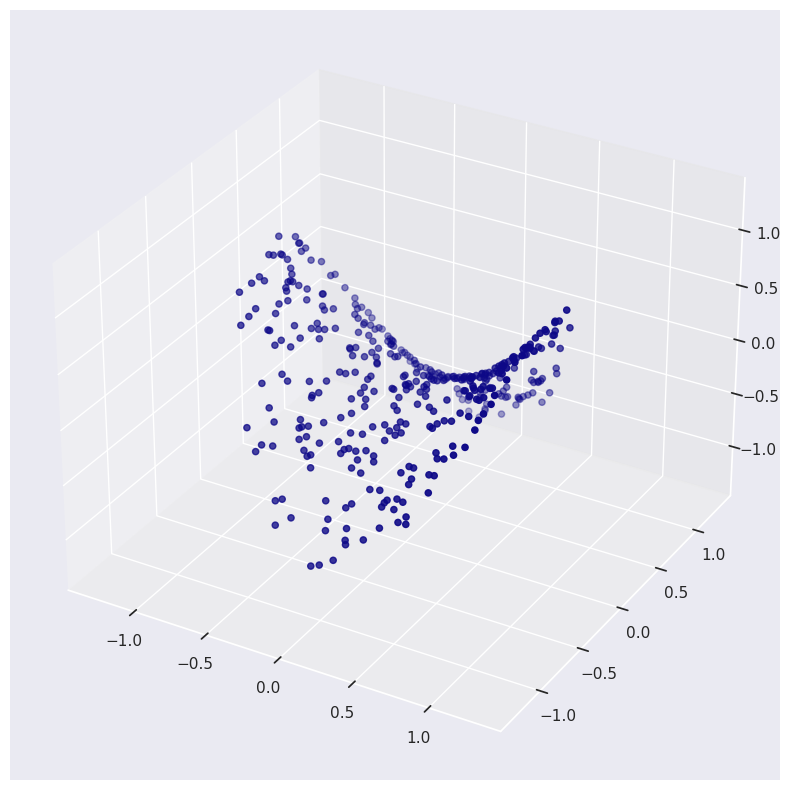

In [43]:
plot_3d(X)

## Baselines

In [44]:
from diffusion_curvature.flattening.radial_ae import radially_flatten_with_ae
from diffusion_curvature.flattening.mioflow_quicktrain import MIOFlowStandard

In [45]:
# Comparisons
from sklearn.decomposition import PCA
def pca_projection(array):
    # Create PCA instance with 2 components
    pca = PCA(n_components=2)
    # Perform PCA on the array
    projected_array = pca.fit_transform(array)
    return projected_array

In [46]:
def uniform_sampling_of_plane(array):
    return np.random.rand(*array.shape)

In [47]:
def mioflattener(array):
    MF = MIOFlowStandard(embedding_dimension=2)
    flattened_array = MF.fit_transform(array)
    return flattened_array

In [48]:
def mioflattener_with_rfae(array):
    MF = MIOFlowStandard(embedding_dimension=2, autoencoder_type="RFAE")
    flattened_array = MF.fit_transform(array)
    return flattened_array

## Run Flattening
We'll define this via a function that takes the dataframe as input and returns it with a new column, containing a flattened version of each neighborhood.

In [49]:
def semifinal_flattener(NBD, flattening_func, recompute=False):
    if flattening_func.__name__ in NBD.columns and not recompute:
        print(f'Already computed {flattening_func.__name__}')
        return NBD
    flattened_spaces = []
    for X in tqdm(NBD['X']):
        flattened_spaces.append(
            flattening_func(X)
        )
    NBD[flattening_func.__name__] = flattened_spaces
    # save updated neighborhoods
    Neighborhoods.to_pickle('~/data/diffusion_curvature/Sampling_Semifinals_Neighborhoods.pkl')
    return NBD

In [50]:
def compute_distances(NBD):
    for flatname in tqdm(NBD.columns[3:]):
        # check if flatname has _dist in it
        if '_dist' not in flatname:
            Xs_flattened = NBD[flatname]
            sampling_dists = []
            for i in trange(len(Xs_flattened)):
                X_r = NBD['X'][i]
                X_f = Xs_flattened[i]
                D = NBD['D'][i]
                sampling_dists.append(
                    sampling_distance(X_r, X_f, D)
                )
            NBD[flatname + '_dist'] = sampling_dists
    return NBD

## Visualizations

In [62]:
def visualize_row_of_flattenings(df, i):
    row = df.iloc[i]

    bb = row['X']
    x = row['pca_projection']
    y = row['uniform_sampling_of_plane']
    z = row['radially_flatten_with_ae']
    # zz = row['mioflattener']
    zzz = row['mioflattener_with_rfae']
    
    labels = {
        'pca_projection': row['pca_projection_dist'],
        'uniform_sampling_of_plane': row['uniform_sampling_of_plane_dist'],
        'radially_flatten_with_ae': row['radially_flatten_with_ae_dist'],
        # 'mioflattener': row['mioflattener_dist'],
        'mioflattener_with_rfae': row['mioflattener_with_rfae_dist'],
        
    }
    
    fig, axs = plt.subplots(1, 5, figsize=(12, 4))
    
    axs[0].scatter(x[:, 0], x[:, 1], c=bb[:,0])
    axs[0].set_title('pca_projection_dist: {:.2f}'.format(labels['pca_projection']))
    axs[0].set_xlabel('Dimension 1')
    axs[0].set_ylabel('Dimension 2')
    
    axs[1].scatter(y[:, 0], y[:, 1],c=bb[:,0])
    axs[1].set_title('uniform_sampling_of_plane_dist: {:.2f}'.format(labels['uniform_sampling_of_plane']))
    axs[1].set_xlabel('Dimension 1')
    axs[1].set_ylabel('Dimension 2')
    
    axs[2].scatter(z[:, 0], z[:, 1],c=bb[:,0])
    axs[2].set_title('radially_flatten_with_ae_dist: {:.2f}'.format(labels['radially_flatten_with_ae']))
    axs[2].set_xlabel('Dimension 1')
    axs[2].set_ylabel('Dimension 2')

    # axs[3].scatter(zz[:, 0], zz[:, 1],c=bb[:,0])
    # axs[3].set_title('mioflattener: {:.2f}'.format(labels['mioflattener']))
    # axs[3].set_xlabel('Dimension 1')
    # axs[3].set_ylabel('Dimension 2')

    axs[4].scatter(zzz[:, 0], zzz[:, 1],c=bb[:,0])
    axs[4].set_title('mioflattener_with_rfae: {:.2f}'.format(labels['mioflattener_with_rfae']))
    axs[4].set_xlabel('Dimension 1')
    axs[4].set_ylabel('Dimension 2')
    
    plt.tight_layout()
    plt.show()

# Results

First we'll compute flattened neighborhoods for each of our functions of interest, 
beginning with the two baselines:

In [52]:
Neighborhoods = semifinal_flattener(Neighborhoods, pca_projection)

  0%|          | 0/14 [00:00<?, ?it/s]

In [53]:
Neighborhoods = semifinal_flattener(Neighborhoods, uniform_sampling_of_plane)

  0%|          | 0/14 [00:00<?, ?it/s]

Then our more serious models:

In [54]:
Neighborhoods = semifinal_flattener(Neighborhoods, radially_flatten_with_ae, recompute=True)

  0%|          | 0/14 [00:00<?, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: T

Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: T

Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: T

Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: T

Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [56]:
# Neighborhoods = semifinal_flattener(Neighborhoods, mioflattener, recompute=False)

In [57]:
Neighborhoods = semifinal_flattener(Neighborhoods, mioflattener_with_rfae, recompute=True)

  0%|          | 0/14 [00:00<?, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Posttraining Epoch: 0it [00:00, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


Training: |                  | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=50` reached

ToyModel(
  (func): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)


Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

## Analysis

In [58]:
Neighborhoods = compute_distances(Neighborhoods)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [60]:
Neighborhoods[["ks","pca_projection_dist","radially_flatten_with_ae_dist","uniform_sampling_of_plane_dist", "mioflattener_with_rfae_dist"]]

,ks,pca_projection_dist,radially_flatten_with_ae_dist,uniform_sampling_of_plane_dist,mioflattener_with_rfae_dist
0,2.0,10.690781,10.752891,10.867780,10.753490
1,0.5,10.590994,10.843232,10.910352,10.824254
2,0.222222,10.609599,10.965137,11.018087,10.924112
3,0.125,10.595838,11.083199,10.947409,10.994595
4,0.08,10.533699,10.778638,11.013225,10.736170
5,0.055556,10.500300,10.825800,10.849798,10.733479
6,0.040816,10.443818,10.987802,10.971039,10.872880
7,"[-4.0, -0.24013586603819764, -0.13510332236676...",10.849545,11.278112,11.207577,10.974908
8,"[-0.25, -0.1615581928118424, -0.19815996875464...",10.964656,10.827454,11.523933,10.835667
9,"[-0.04938271604938271, -0.04751753894035385, -...",10.836122,10.856928,11.875291,10.850279


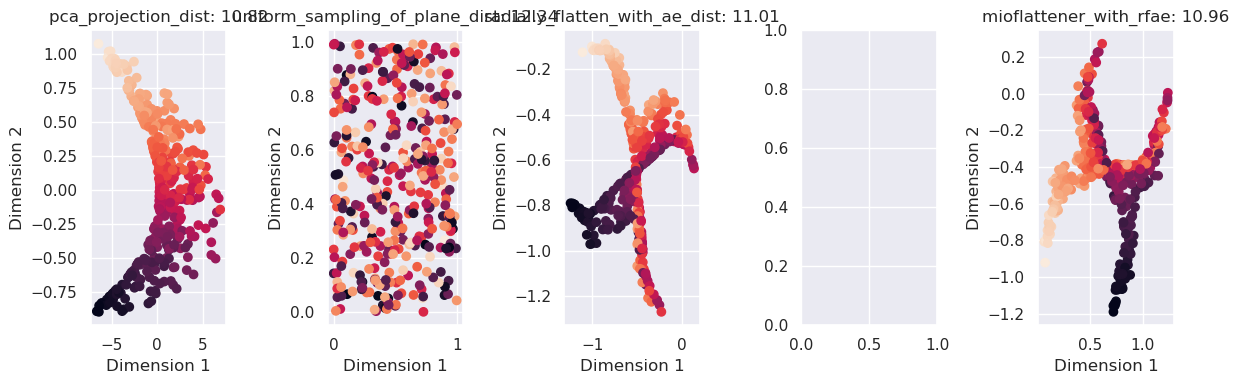

In [63]:
visualize_row_of_flattenings(Neighborhoods,13)

# Conclusion

MioFlow combined with the Radially Flattening Autoencoder outperforms everything except a standard PCA projection.
For our positively curved data, this makes sense. PCA isn't reliable in high dimensions, or with lots of noise, but going from 3 to 2 dimensions should transfer sampling pretty evenly. The more troubling sign is that our Mio flattener does no better than PCA on the saddles.